# Fitting of tunneling spectroscopy measurments
In this notebook, some pyusadel routines are used to fit NS tunneling spectroscopy data.

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from pyusadel import (
    DifferentialOperators,
    UsadelProblem,
    gen_assemble_fns,
    solve_usadel,
    thermal_broadening,
    trivial_diffops,
)
from scipy.optimize import curve_fit

In [57]:
def fit(e_ax_exp, dos_exp, verbose: bool = False):
    """Fit the experimental data.

    Parameters:
    -------
    e_ax_exp : np.ndarray
        Energy axis of the experimental data.
    dos_exp : np.ndarray
        Spectroscopy data.
    verbose : bool
        Whether printing the status.
    """

    N_0 = (dos_exp[0] + dos_exp[-1]) / 2
    Delta_0 = 0.250

    # Initial guess
    # N_0, Delta, h, tau_sf_inv, Gamma, T
    p0 = [
        N_0,
        Delta_0,
        Delta_0 * 0.1,
        Delta_0 * 0.01,
        Delta_0 * 0.01,
        Delta_0 * 1e-4,
        1e-2,
    ]

    # Bounds
    bounds = (
        [
            N_0 * 0.7,
            Delta_0 * 0.0,
            Delta_0 * 0.0,
            Delta_0 * 0.0,
            Delta_0 * 0.0,
            Delta_0 * 1e-5,
            1e-5,
        ],
        [
            N_0 * 1.3,
            Delta_0 * 2.0,
            Delta_0 * 1.0,
            Delta_0 * 0.5,
            Delta_0 * 0.5,
            Delta_0 * 1e-1,
            1e-2,
        ],
    )

    do = trivial_diffops()

    theta = np.ones((e_ax_exp.shape[0], 1), dtype=complex)
    M_x = np.zeros((e_ax_exp.shape[0], 1), dtype=complex)

    def wrapper(omega_ax_exp, *params):
        if verbose:
            print(
                f"""N_0 = {params[0]:3.2f}, Delta = {params[1]:3.2f}, h = {params[2]:3.2f}, tau_sf_inv = {params[3]:3.2f},  tau_so_inv = {params[4]:3.2f}, Gamma = {params[5]:3.2e}, T = {params[6]:3.2e}"""
            )
        N_0, Delta, h, tau_sf_inv, tau_so_inv, Gamma, T = params

        assemble_fns = gen_assemble_fns(
            D=0,
            diff_ops=do,
            h_x=h,
            h_y=0,
            h_z=0,
            tau_so_inv=tau_so_inv,
            tau_sf_inv=tau_sf_inv,
            Gamma=Gamma,
        )

        solve_usadel(
            assemble_fns=assemble_fns,
            h_x=h,
            h_y=0,
            h_z=0,
            theta=theta,
            M_x=M_x,
            M_y=0,
            M_z=0,
            Delta=Delta,
            omega_ax=-1j * omega_ax_exp,
            gamma=1.0,
            tol=1e-6,
            max_iter=1000,
            print_exit_status=False,
            use_dense=True,
        )

        M_0 = np.sqrt(1 + M_x**2)

        return thermal_broadening(
            e_ax_exp, N_0 * np.real(M_0 * np.cos(theta))[:, 0], T=T
        )

    return curve_fit(
        f=wrapper,
        xdata=e_ax_exp,
        ydata=dos_exp,
        p0=p0,
        # sigma=None,
        # absolute_sigma=False,
        check_finite=True,
        bounds=bounds,
        # method=None,
        # jac=None,
        # full_output=True,
    )

In [58]:
data = np.loadtxt("MDC004_cuts/MDC004_12_RunID_15_cut-24mT.dat")
e_ax_exp = data[:, 0]
dos_exp = data[:, 1]

Text(0, 0.5, '$I$ (?)')

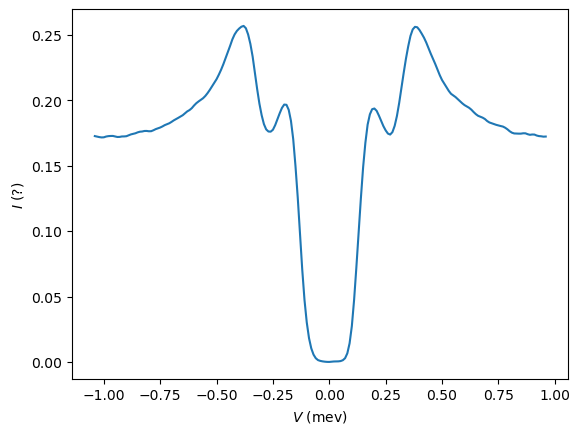

In [59]:
fig, ax = plt.subplots()
ax.plot(e_ax_exp, dos_exp)
ax.set_xlabel(r"$V$ (mev)")
ax.set_ylabel(r"$I$ (?)")

In [60]:
popt, pcov = fit(e_ax_exp, dos_exp, verbose=True)

N_0 = 0.17, Delta = 0.25, h = 0.03, tau_sf_inv = 0.00,  tau_so_inv = 0.00, Gamma = 2.50e-05, T = 1.00e-02
N_0 = 0.17, Delta = 0.25, h = 0.03, tau_sf_inv = 0.00,  tau_so_inv = 0.00, Gamma = 2.50e-05, T = 1.00e-02
N_0 = 0.17, Delta = 0.25, h = 0.03, tau_sf_inv = 0.00,  tau_so_inv = 0.00, Gamma = 2.50e-05, T = 1.00e-02
N_0 = 0.17, Delta = 0.25, h = 0.03, tau_sf_inv = 0.00,  tau_so_inv = 0.00, Gamma = 2.50e-05, T = 1.00e-02
N_0 = 0.17, Delta = 0.25, h = 0.03, tau_sf_inv = 0.00,  tau_so_inv = 0.00, Gamma = 2.50e-05, T = 1.00e-02
N_0 = 0.17, Delta = 0.25, h = 0.03, tau_sf_inv = 0.00,  tau_so_inv = 0.00, Gamma = 2.50e-05, T = 1.00e-02
N_0 = 0.17, Delta = 0.25, h = 0.03, tau_sf_inv = 0.00,  tau_so_inv = 0.00, Gamma = 2.50e-05, T = 1.00e-02
N_0 = 0.17, Delta = 0.25, h = 0.03, tau_sf_inv = 0.00,  tau_so_inv = 0.00, Gamma = 2.50e-05, T = 1.00e-02
N_0 = 0.17, Delta = 0.23, h = 0.04, tau_sf_inv = 0.01,  tau_so_inv = 0.02, Gamma = 7.52e-03, T = 1.00e-02
N_0 = 0.17, Delta = 0.23, h = 0.04, tau_sf_inv

In [99]:
output_str = f"""\
N_0 = {popt[0]:3.3f} ({pcov[0, 0]:3.2e}) 
Delta = {popt[1]:3.3f} ({pcov[1, 1]:3.2e})
h = {popt[2]:3.3f} ({pcov[2, 2]:3.2e})
tau_sf_inv = {popt[3]:3.3f} ({pcov[3, 3]:3.2e})
tau_sf_inv = {popt[4]:3.3f} ({pcov[4, 4]:3.2e})
Gamma = {popt[5]:3.2e} ({pcov[5, 5]:3.2e})
T = {popt[6]:3.2e} ({pcov[6, 6]:3.2e})\
"""

print(output_str)

N_0 = 0.177 (4.66e-07) 
Delta = 0.250 (9.55e-06)
h = 0.097 (9.42e-06)
tau_sf_inv = 0.026 (2.48e-05)
tau_sf_inv = 0.125 (3.07e-04)
Gamma = 5.71e-03 (3.85e-06)
T = 1.00e-02 (5.03e-06)


In [110]:
N_0, Delta, h, tau_sf_inv, tau_so_inv, Gamma, T = popt

N_0 = 0.17
# Delta = 0.25
# h = 0.10
tau_sf_inv = 0.026
tau_so_inv = 0.120
Gamma = 2.00e-04
# T = 10e-3

up = UsadelProblem(
    Nsites=1,
    diff_ops=trivial_diffops(),
    h_x=np.array([0.0]) + h,
    h_y=np.array([0.0]),
    h_z=np.array([0.0]),
    tau_sf_inv=np.array([0.0]) + tau_sf_inv,
    tau_so_inv=np.array([0.0]) + tau_so_inv,
    D=0,
    T=T,
    Gamma=Gamma,
)

up.Delta = np.array([Delta])

up.set_real_omega_ax(-2, 2, 401)
up.solve_spectral()

DOS_fit = thermal_broadening(up.get_omega_ax_r(), N_0 * up.get_dos(), T)
DOS_fitu = thermal_broadening(
    up.get_omega_ax_r(), N_0 * up.get_spin_resolved_dos("x")[0], T
)
DOS_fitd = thermal_broadening(
    up.get_omega_ax_r(), N_0 * up.get_spin_resolved_dos("x")[1], T
)

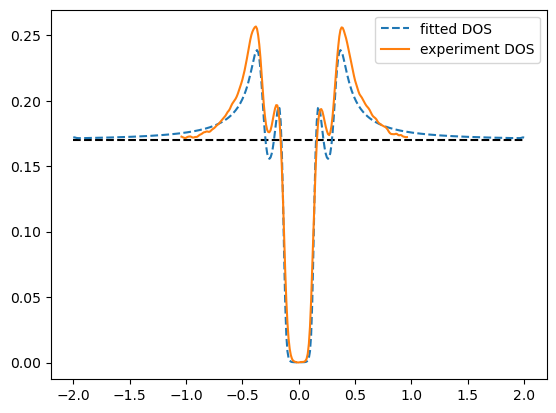

In [111]:
plt.hlines([N_0], -2, 2, "k", linestyles="--")
plt.plot(up.get_omega_ax_r(), DOS_fit, "--", label="fitted DOS")
# plt.plot(
#     up.get_omega_ax_r(),
#     DOS_fitu,
#     "--",
#     linewidth=1,
#     label="DOSu",
# )
# plt.plot(
#     up.get_omega_ax_r(),
#     DOS_fitd,
#     "--",
#     linewidth=1,
#     label="DOSd",
# )
plt.plot(e_ax_exp, dos_exp, label="experiment DOS")

plt.legend()